In [1]:
import time

import h5py
import pandas as pd
import scipy as sp
import pennylane as qml
from pennylane import numpy as np
import qiskit as qk
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [2]:
events = np.load('10k_dijet.npy', requires_grad=False)

In [3]:
print(events)
scaler = MinMaxScaler(feature_range=(0, sp.pi))
events = scaler.fit_transform(events)
for i in range(events.shape[1]):
    print(np.max((events[:, i])))
print(events)

[[1221.1836814  1201.61775869 3206.03845303]
 [1723.56342874 1630.76457405 3980.32116227]
 [1680.72056215 1327.01720279 3481.8456915 ]
 ...
 [1254.80445313 1006.14151121 2263.08600202]
 [1326.53791698 1091.19951254 2693.48429379]
 [1690.21255361 1499.72886537 3193.7702817 ]]
3.141592653589793
3.1415926535897927
3.141592653589793
[[0.0328303  0.96550209 1.02392057]
 [0.81145221 1.45798795 1.46333242]
 [0.74505146 1.10940961 1.18044346]
 ...
 [0.08493803 0.74117492 0.48878725]
 [0.19611538 0.83878688 0.73304184]
 [0.75976278 1.3076123  1.01695828]]


In [4]:
n_shots = 5000
dev1 = qml.device('default.qubit', wires=6, shots=n_shots)

@qml.qnode(dev1)
def circuit(params, event=None):
    qml.broadcast(qml.RX, wires=[0, 1, 2], pattern='single', parameters=event)

    qml.broadcast(qml.RY, wires=[0, 1, 2], pattern='single', parameters=params)
    qml.broadcast(qml.CNOT, wires=[0, 1, 2], pattern='all_to_all')
    
    qml.Hadamard(wires=5)
    qml.broadcast(qml.CSWAP, wires=[5, 1, 2, 3, 4], pattern=[[5, 1, 3], [5, 2, 4]])
    qml.Hadamard(wires=5)

    qml.PauliX(wires=5)
    
    return qml.expval(qml.PauliZ(wires=5))

In [5]:
params = np.array([0.1, 0.2, 0.4], requires_grad=True)
ansatz_draw = qml.draw(circuit, expansion_strategy='device', decimals=None)(params, event=events[0])
print(ansatz_draw)
with open('vanilla_ansatz', "w") as f:
    f.write(ansatz_draw)

0: ──RX──RY─╭●─╭●──────────────────────┤     
1: ──RX──RY─╰X─│──╭●─╭SWAP─────────────┤     
2: ──RX──RY────╰X─╰X─│─────╭SWAP───────┤     
3: ──────────────────├SWAP─│───────────┤     
4: ──────────────────│─────├SWAP───────┤     
5: ──H───────────────╰●────╰●─────H──X─┤  <Z>


In [6]:
print(np.round(qml.metric_tensor(circuit, approx='block-diag')(params, event=events[0]), 8))

[[ 0.24949824 -0.00041392  0.000768  ]
 [-0.00041392  0.07711036 -0.000494  ]
 [ 0.000768   -0.000494    0.0651    ]]


In [7]:
steps = 500

gd_cost = []
opt = qml.GradientDescentOptimizer(0.5)
theta = np.array([sp.pi/2, sp.pi/2, sp.pi/2], requires_grad=True)

for _ in range(steps):
    if (_%10 == 0):
        print('Step %d with cost %.4f' % (_, circuit(theta, event=events[0])))
    theta = opt.step(circuit, theta, event=events[0])
    gd_cost.append(circuit(theta, event=events[0]))

Step 0 with cost -0.2412
Step 10 with cost -0.2324
Step 20 with cost -0.2512
Step 30 with cost -0.2496
Step 40 with cost -0.2928
Step 50 with cost -0.4720
Step 60 with cost -0.5808
Step 70 with cost -0.5816
Step 80 with cost -0.5920
Step 90 with cost -0.6088
Step 100 with cost -0.5992
Step 110 with cost -0.5892
Step 120 with cost -0.6120
Step 130 with cost -0.6008
Step 140 with cost -0.5792
Step 150 with cost -0.5868
Step 160 with cost -0.5832
Step 170 with cost -0.5680
Step 180 with cost -0.5892
Step 190 with cost -0.6024
Step 200 with cost -0.6084
Step 210 with cost -0.5924
Step 220 with cost -0.6000
Step 230 with cost -0.6064
Step 240 with cost -0.5772
Step 250 with cost -0.5740
Step 260 with cost -0.6088
Step 270 with cost -0.5996
Step 280 with cost -0.5964
Step 290 with cost -0.6136
Step 300 with cost -0.5832
Step 310 with cost -0.6000
Step 320 with cost -0.5968
Step 330 with cost -0.5920
Step 340 with cost -0.5896
Step 350 with cost -0.6020
Step 360 with cost -0.5980
Step 370 wit

In [8]:
steps = 500

qng_cost = []
opt = qml.QNGOptimizer(0.1)
theta = np.array([sp.pi/2, sp.pi/2, sp.pi/2], requires_grad=True)

for _ in range(steps):
    if (_%10 == 0):
        print('Step %d with cost %.4f' % (_, circuit(theta, event=events[0])))
    theta = opt.step(circuit, theta, event=events[0])
    qng_cost.append(circuit(theta, event=events[0]))

Step 0 with cost -0.2632
Step 10 with cost -0.2380
Step 20 with cost -0.3636
Step 30 with cost -0.5728
Step 40 with cost -0.5888
Step 50 with cost -0.5844
Step 60 with cost -0.5960
Step 70 with cost -0.5912
Step 80 with cost -0.5988
Step 90 with cost -0.6036
Step 100 with cost -0.5880
Step 110 with cost -0.5768
Step 120 with cost -0.6028
Step 130 with cost -0.5744
Step 140 with cost -0.5876
Step 150 with cost -0.6120
Step 160 with cost -0.6084
Step 170 with cost -0.5768
Step 180 with cost -0.6024
Step 190 with cost -0.5840
Step 200 with cost -0.5792
Step 210 with cost -0.6060
Step 220 with cost -0.5924
Step 230 with cost -0.6104
Step 240 with cost -0.6068
Step 250 with cost -0.6156
Step 260 with cost -0.5880
Step 270 with cost -0.5724
Step 280 with cost -0.5820
Step 290 with cost -0.5800
Step 300 with cost -0.5988
Step 310 with cost -0.5984
Step 320 with cost -0.6116
Step 330 with cost -0.5780
Step 340 with cost -0.5760
Step 350 with cost -0.6088
Step 360 with cost -0.6080
Step 370 wit

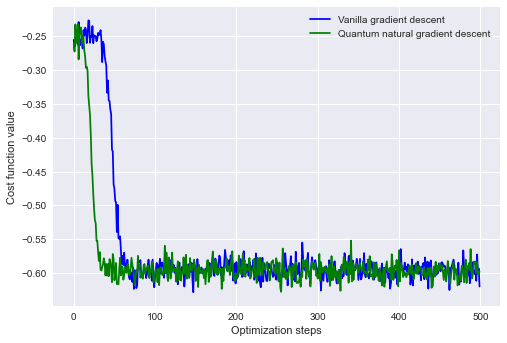

In [9]:
plt.style.use("seaborn")
plt.plot(gd_cost, "b", label="Vanilla gradient descent")
plt.plot(qng_cost, "g", label="Quantum natural gradient descent")

plt.ylabel("Cost function value")
plt.xlabel("Optimization steps")
plt.legend()
plt.show()

Step 1 with cost -0.0610
Step 26 with cost -0.6338
Step 51 with cost -0.5743
Step 76 with cost -0.5865
Step 101 with cost -0.5554
Step 126 with cost -0.6127
Step 151 with cost -0.5828
Step 176 with cost -0.5687
Step 201 with cost -0.5700
Step 226 with cost -0.6458
Step 251 with cost -0.5025
Step 276 with cost -0.6092
Step 301 with cost -0.5864
Step 326 with cost -0.5802
Step 351 with cost -0.6010
Step 376 with cost -0.5472
Step 401 with cost -0.6096
Step 426 with cost -0.6006
Step 451 with cost -0.6134
Step 476 with cost -0.5627
Step 499 with cost -0.4700


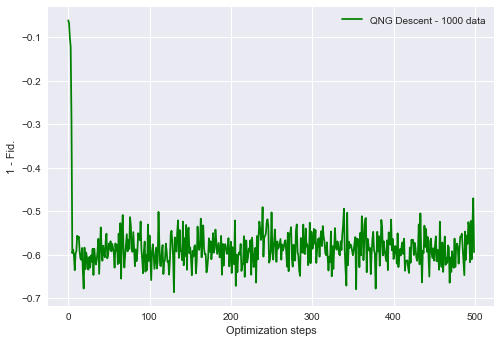

QML Optimization in 719.15 seconds


In [11]:
# rng = np.random.default_rng(seed=42)
rng = np.random.default_rng()
qng_cost = [[], [], [], [], []]
opt = qml.QNGOptimizer(1e-5)
ix = 0
start_time = time.time()
# for train_size, steps in zip([1, 10, 100, 1000, 10000], [500, 200, 50, 50, 50]):
# for train_size, steps in zip([1, 10, 100], [500, 200, 50]):
# for train_size, steps in zip([1000, 10000], [50, 50]):
for train_size, steps in zip([1000], [500]):
    best_perf = [100000, np.array([])]
    theta = sp.pi * rng.random(size=3, requires_grad=True)
    event_sub = rng.choice(events, train_size, replace=False)
    for _ in range(steps):
        
        if train_size > 32:
            event_batch = rng.choice(event_sub, 32, replace=False)
        else:
            event_batch = event_sub
        
        grads = np.zeros((event_batch.shape[0], theta.shape[0]))
        costs = np.zeros(event_batch.shape[0])
        
        if (_%25 == 1 or _==(steps-1)):
            print('Step %d with cost %.4f' % (_, qng_cost[ix][-1]))
            
        for i in range(event_batch.shape[0]):
            fub_stud = qml.metric_tensor(circuit, approx='block-diag')(theta, event=event_batch[i]) # doesnt compute fubiny-study automatically??
            grads[i] = np.matmul(fub_stud, opt.compute_grad(circuit, (theta, event_batch[i]), {})[0][0]) # isn't already anti-gradient??
            costs[i] = circuit(theta, event=event_batch[i])
        if best_perf[0] > costs.mean(axis=0):
            best_perf[0] = costs.mean(axis=0)
            best_perf[1] = theta
        theta = theta - np.sum(grads, axis=0)
        qng_cost[ix].append(costs.mean(axis=0))

    np.save('best%.e_data_theta' % train_size, best_perf[1])
    plt.figure(train_size)
    plt.style.use("seaborn")
    plt.plot(qng_cost[ix], "g", label="QNG Descent - %d data" % train_size)
    plt.ylabel("1 - Fid.")
    plt.xlabel("Optimization steps")
    plt.legend()
    plt.savefig("QNG_Descent-%d_data.pdf" % train_size)
    plt.show()
    ix += 1
    
end_time = time.time()
exec_time = end_time-start_time
print(f'QML Optimization in {exec_time:.2f} seconds')

[ 0.44561076  0.00715541 -0.00968506]


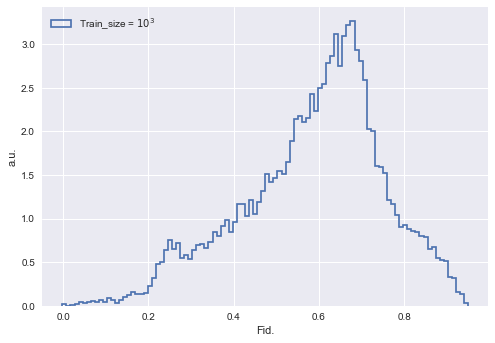

In [12]:
# Histogram plots
event_test = rng.choice(events, 30000, axis=0, replace=False)[10000:, :]
test_sub = rng.choice(event_test, 15000, replace=False)

# for j in range(5):
#     tktheta = np.load('best1e+0%d_data_theta.npy' % j)
#     print(tktheta)
#     cost = []

#     for i in range(15000):
#         cost.append(circuit(tktheta, event=test_sub[i, :]))

#     fid = -1 * np.array(cost)
#     plt.hist(fid, bins=100, density=True, histtype='step', linewidth=1.7, label='Train_size = $10^{%d}$' % j)
#     plt.xlabel('Fid.')
#     plt.ylabel('a.u')
#     plt.legend(loc='upper left')
    
# plt.savefig("fid_hist.pdf")

tktheta = np.load('best1e+03_data_theta.npy')
print(tktheta)
cost = []

for i in range(15000):
    cost.append(circuit(tktheta, event=test_sub[i, :]))

fid = -1 * np.array(cost)
plt.hist(fid, bins=100, density=True, histtype='step', linewidth=1.7, label='Train_size = $10^{3}$')
plt.xlabel('Fid.')
plt.ylabel('a.u.')
plt.legend(loc='upper left')
    
plt.savefig("fid_hist.pdf")

In [59]:
# rng = np.random.default_rng(seed=42)
rng = np.random.default_rng()
qng_cost = [[], [], [], [], []]
opt = qml.QNGOptimizer(1e-6)
ix = 0

for train_size in [1, 10, 100, 1000, 10000]:
    step = 0
    best_perf = [100000, np.zeros(3)]
    theta = sp.pi * rng.random(size=3, requires_grad=True)
    event_sub = rng.choice(events, train_size, replace=False)
    while True:
        if train_size > 30:
            event_batch = rng.choice(event_sub, 30, replace=False)
        else:
            event_batch = event_sub
        
        grads = np.zeros((event_batch.shape[0], theta.shape[0]))
        costs = np.zeros(event_batch.shape[0])
        
        # if step%25 == 1:
        #     print('Step %d with cost %.4f' % (step, qng_cost[ix][-1]))
            
        for i in range(event_batch.shape[0]):
            fub_stud = qml.metric_tensor(circuit, approx='block-diag')(theta, event=event_batch[i]) # doesnt compute fubiny-study automatically??
            grads[i] = np.matmul(fub_stud, opt.compute_grad(circuit, (theta, event_batch[i]), {})[0][0]) # isn't already anti-gradient??
            costs[i] = circuit(theta, event=event_batch[i])
        if best_perf[0] > costs.mean(axis=0):
            best_perf[0] = costs.mean(axis=0)
            best_perf[1] = theta
            print(best_perf)
        theta = theta - np.sum(grads, axis=0)
        qng_cost[ix].append(costs.mean(axis=0))
        
        if np.nonzero(np.isclose(np.sum(grads, axis=0), np.zeros(theta.shape[0]), rtol=1e-05, atol=1e-08, equal_nan=False))[0].shape == 0:
            break
        elif step == 5000:
            break
        step += 1

    np.save('cont_best%.e_data_theta' % train_size, best_perf[1])
    plt.figure(train_size)
    plt.style.use("seaborn")
    plt.plot(qng_cost[ix], "g", label="QNG Descent - %d data" % train_size)
    plt.ylabel("1 - Fid.")
    plt.xlabel("Optimization steps")
    plt.legend()
    plt.savefig("cont_QNG_Descent-%d_data.pdf" % train_size)
    plt.show()
    ix += 1

[tensor(0.2656, requires_grad=True), tensor([1.29230888, 3.12469351, 2.53035559], requires_grad=True)]
[tensor(0.232, requires_grad=True), tensor([1.22267722, 3.12535985, 2.52689063], requires_grad=True)]
[tensor(0.2092, requires_grad=True), tensor([1.16014884, 3.12643418, 2.52310686], requires_grad=True)]
[tensor(0.1932, requires_grad=True), tensor([1.09292811, 3.12658291, 2.52070353], requires_grad=True)]
[tensor(0.188, requires_grad=True), tensor([1.02155306, 3.12652284, 2.52054996], requires_grad=True)]
[tensor(0.1748, requires_grad=True), tensor([0.9597462 , 3.12695252, 2.52176759], requires_grad=True)]
[tensor(0.1596, requires_grad=True), tensor([0.90291876, 3.12827639, 2.52380225], requires_grad=True)]
[tensor(0.1184, requires_grad=True), tensor([0.84564536, 3.12862865, 2.52407334], requires_grad=True)]
[tensor(0.1072, requires_grad=True), tensor([0.69133907, 3.12664281, 2.52983096], requires_grad=True)]
[tensor(0.1028, requires_grad=True), tensor([0.64648991, 3.12702626, 2.5327

KeyboardInterrupt: 

[3.13629367 0.00424592 0.00498338]
[-1.25882078e-03  3.14854235e+00  3.14346229e+00]
[ 3.10488215 -0.00629173  0.00315981]
[ 3.12180562e+00  6.27218328e+00 -2.66279434e-03]
[-0.02629311  3.14918111  3.15211228]


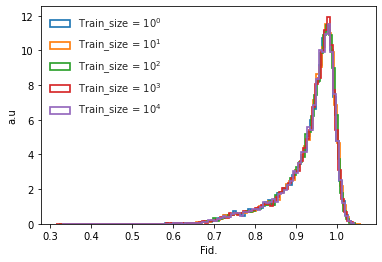

In [8]:
# Histogram plots
rng = np.random.default_rng()
event_test = rng.choice(events, 30000, axis=0, replace=False)[10000:, :]
test_sub = rng.choice(event_test, 15000, replace=False)

for j in range(5):
    tktheta = np.load('cont_best1e+0%d_data_theta.npy' % j)
    print(tktheta)
    cost = []

    for i in range(15000):
        cost.append(circuit(tktheta, event=test_sub[i, :]))

    fid = 1 - np.array(cost)
    plt.hist(fid, bins=100, density=True, histtype='step', linewidth=1.7, label='Train_size = $10^{%d}$' % j)
    plt.style.use("seaborn")
    plt.xlabel('Fid.')
    plt.ylabel('a.u')
    plt.legend(loc='upper left')
    
plt.savefig("cont_fid_hist.pdf")